In [1]:
!pip install --upgrade torch-summary

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import string

# Hyperparameters


In [3]:
DATA_DIR='/kaggle/input/captcha-dataset'
BATCH_SIZE=128
VAL_SPLIT=0.05

#AFFN
AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=4

#CRNN
CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26*2+10
OUTPUT_LENGTH=5

#Train
SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=40

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset


The dataset using in this notebook can be obtained from : https://www.kaggle.com/datasets/parsasam/captcha-dataset


In [5]:
def get_dataloaders(data_dir, batch_size=32, val_split=0.2, shuffle=True, num_workers=2):
    
    # Define the character set (vocabulary)
    characters = string.ascii_letters + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0] for f in self.image_paths]  # Extract filename as label
        
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]
            
            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding
            
            if self.transform:
                image = self.transform(image)
            
            return image, label_tensor
    
    transform = transforms.Compose([
        transforms.Resize((40, 150)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])
    
    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    
    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader


In [6]:
train_loader,val_loader=get_dataloaders(DATA_DIR, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, shuffle=True)

In [7]:
for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 1, 40, 150])
torch.Size([128, 5])


# Model


## AFFN


In [8]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )

In [9]:
# summary(Encoder(2,AFFN_KERNEL,AFFN_STRIDE),(4,36,146))

In [10]:
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [11]:
# summary(Decoder(2,AFFN_KERNEL,AFFN_STRIDE),(16,32,142))

In [12]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        # self.test=nn.Linear(1,2)
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))
            
    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i]) 
                residuals.append(x * self.alpha[i])
    
        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()
    
        return x
        

In [13]:
# AFFN(3).to(device)(torch.randn((1,1,40,150)).to(device)).shape

## CRNN


In [ ]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length
        self.vocab_size = vocab_size
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)
        
        lstm_input = latent.unsqueeze(1)  # Shape: (batch_size, 1, latent_dim)
        
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        
        outputs = []
        
        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)
            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)
            outputs.append(logits)
            
        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 5, vocab_size)
        
        return outputs

In [15]:
output=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)(torch.zeros((2,64,256,256)).to(device))

In [16]:
output.shape

torch.Size([2, 5, 62])

In [17]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output
        

In [18]:
CaptchaCrackNet()

CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [19]:
# CaptchaCrackNet()(torch.randn(1,1,40,150))

In [20]:
for X,y in train_loader:
    print(y.shape)
    break

torch.Size([128, 5])


# Train Loop


In [21]:
def loss_fn(preds,target):
    ce_loss=F.cross_entropy(preds,target)
    
    return ce_loss

def asr(preds,target):
    preds_argmax=torch.argmax(preds,dim=-1)
    asr=(preds_argmax==target).sum(dim=-1)/preds.shape[1]
    return asr.mean()


def train(model,train_loader,val_loader,optimizer,loss_fn,epochs):
    train_history=[]
    val_history=[]
    asr_history=[]
    model.to(device)
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        model.train()
        avg_loss=0
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):
            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)
            
            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()
            
            avg_loss+=loss.item()
        avg_loss/=len(train_loader)
        train_history.append(avg_loss)
        print(f"Loss: {avg_loss}")

        eval_loss=0
        asr_avg=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
        
                    eval_loss+=loss.item()
                    
                    asr_val=asr(preds,y)
                    asr_avg+=asr_val.item()
                    
                eval_loss/=len(val_loader)
                asr_avg/=len(val_loader)
                asr_history.append(asr_avg)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}",end=' ')
                print(f"Val ASR: {asr_avg}")

        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')
    return train_history,val_history,asr_history

In [22]:
model=CaptchaCrackNet().to(device)
optimizer=torch.optim.Adam(model.parameters())

In [23]:
train_history,val_history,asr_history=train(model,train_loader,val_loader,optimizer,nn.CrossEntropyLoss(),EPOCHS)

Epoch 1:


Progress: 100%|██████████| 840/840 [07:03<00:00,  1.98it/s]


Loss: 4.052413977611632


Progress: 100%|██████████| 45/45 [00:21<00:00,  2.08it/s]


Val Loss: 3.9866638236575658 Val ASR: 0.04289186584452788
Epoch 2:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 3.835330656880424


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.04it/s]


Val Loss: 3.656300279829237 Val ASR: 0.10192129794094297
Epoch 3:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 3.3169927097502208


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.01it/s]


Val Loss: 3.0259183989630807 Val ASR: 0.19906250403987036
Epoch 4:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 2.8041472619488124


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.33it/s]


Val Loss: 2.568498881657918 Val ASR: 0.29412699341773985
Epoch 5:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 2.4009256737572806


Progress: 100%|██████████| 45/45 [00:06<00:00,  7.03it/s]


Val Loss: 2.1844460593329535 Val ASR: 0.37613922357559204
Epoch 6:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 2.0626625957943143


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.67it/s]


Val Loss: 1.893160753779941 Val ASR: 0.4473958412806193
Epoch 7:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 1.80938186503592


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.71it/s]


Val Loss: 1.6706268151601156 Val ASR: 0.5087781177626716
Epoch 8:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 1.6036597958632879


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.16it/s]


Val Loss: 1.499862167570326 Val ASR: 0.5503306885560354
Epoch 9:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 1.4305854519208272


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.56it/s]


Val Loss: 1.3587690353393556 Val ASR: 0.5899305635028416
Epoch 10:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 1.2911712940250124


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


Val Loss: 1.2521130032009549 Val ASR: 0.6148264050483704
Saving model
Epoch 11:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.64it/s]


Loss: 1.1733760906117303


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.56it/s]


Val Loss: 1.164157599873013 Val ASR: 0.6451141079266866
Epoch 12:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 1.0778878458199046


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Val Loss: 1.069951558113098 Val ASR: 0.668217600716485
Epoch 13:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 0.9978216652359281


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Val Loss: 1.0125984350840251 Val ASR: 0.6868039157655504
Epoch 14:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 0.9281207893575941


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


Val Loss: 0.9719425015979343 Val ASR: 0.6995056298043992
Epoch 15:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 0.8685314206849961


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.02it/s]


Val Loss: 0.9242796474032932 Val ASR: 0.7089980231391059
Epoch 16:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.8168595678749538


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


Val Loss: 0.8844792511728075 Val ASR: 0.7197057008743286
Epoch 17:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.7732070266490891


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.78it/s]


Val Loss: 0.8541429705089993 Val ASR: 0.7306051664882236
Epoch 18:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.733486017371927


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.31it/s]


Val Loss: 0.8315996381971571 Val ASR: 0.7340013292100694
Epoch 19:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.6987430005556061


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Val Loss: 0.800795582930247 Val ASR: 0.7435813599162632
Epoch 20:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.6692107871174813


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.72it/s]


Val Loss: 0.7921854509247674 Val ASR: 0.7465046458774143
Saving model
Epoch 21:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.6416698932647705


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Val Loss: 0.7702642374568516 Val ASR: 0.7537020617061191
Epoch 22:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.6150889965040344


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.03it/s]


Val Loss: 0.7595647401279874 Val ASR: 0.7561260024706523
Epoch 23:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.5916300900635265


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Val Loss: 0.7548026455773248 Val ASR: 0.7581051654285855
Epoch 24:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.5710732735693455


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.28it/s]


Val Loss: 0.7344204703966777 Val ASR: 0.7652050362692939
Epoch 25:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.5524667428008148


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.21it/s]


Val Loss: 0.7219729158613417 Val ASR: 0.766688166724311
Epoch 26:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.5343104449766023


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.20it/s]


Val Loss: 0.7175377302699619 Val ASR: 0.7678687254587809
Epoch 27:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.518069890212445


Progress: 100%|██████████| 45/45 [00:06<00:00,  6.99it/s]


Val Loss: 0.7094164331754048 Val ASR: 0.7725281119346619
Epoch 28:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.5025881532757055


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


Val Loss: 0.7066324538654751 Val ASR: 0.773941797680325
Epoch 29:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4895866157753127


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.16it/s]


Val Loss: 0.6968430015775893 Val ASR: 0.7789170053270128
Epoch 30:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.47499851350273403


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Val Loss: 0.6914375940958659 Val ASR: 0.7806812180413141
Saving model
Epoch 31:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4635334141907238


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


Val Loss: 0.6869497431649102 Val ASR: 0.7790773895051745
Epoch 32:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4502728192224389


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.09it/s]


Val Loss: 0.6804303447405498 Val ASR: 0.7829414751794603
Epoch 33:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4406353890541054


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.61it/s]


Val Loss: 0.6876890619595846 Val ASR: 0.7817576156722175
Epoch 34:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4308471338025161


Progress: 100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


Val Loss: 0.6869145631790161 Val ASR: 0.7836260000864664
Epoch 35:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.61it/s]


Loss: 0.4211944654583931


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.07it/s]


Val Loss: 0.6885705762439304 Val ASR: 0.7832159360249837
Epoch 36:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 0.41224846421253114


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.62it/s]


Val Loss: 0.6829795572492812 Val ASR: 0.7846990784009298
Epoch 37:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 0.4029039045529706


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.27it/s]


Val Loss: 0.6741407023535835 Val ASR: 0.787521505355835
Epoch 38:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 0.3943528013569968


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.74it/s]


Val Loss: 0.6802733076943291 Val ASR: 0.7845701085196601
Epoch 39:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.62it/s]


Loss: 0.38547619474785666


Progress: 100%|██████████| 45/45 [00:05<00:00,  8.26it/s]


Val Loss: 0.6722084376547072 Val ASR: 0.7908432682355245
Epoch 40:


Progress: 100%|██████████| 840/840 [02:29<00:00,  5.63it/s]


Loss: 0.37890758681155384


Progress: 100%|██████████| 45/45 [00:05<00:00,  7.77it/s]

Val Loss: 0.6774577935536702 Val ASR: 0.7907787733607822
Saving model


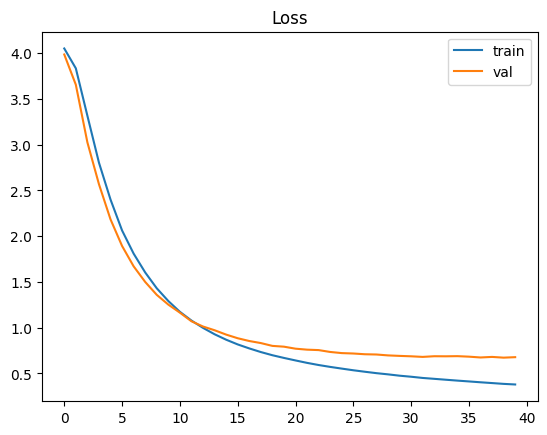

In [24]:
import matplotlib.pyplot as plt
plt.plot(train_history,label='train')
plt.plot(val_history,label='val')
plt.title("Loss")
plt.legend()
plt.show()

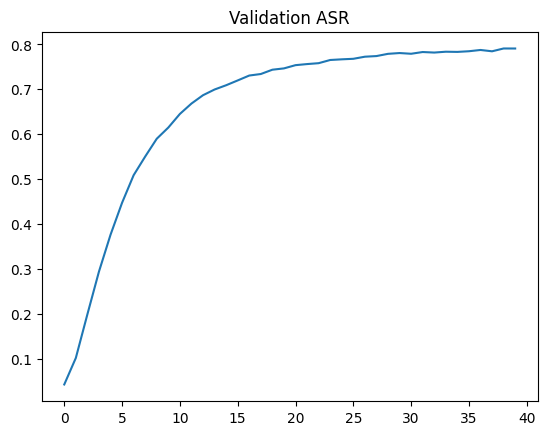

In [25]:
plt.plot(asr_history)
plt.title("Validation ASR")
plt.show()

# Results


In [26]:
characters = string.ascii_letters + string.digits  # Uppercase + lowercase + digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

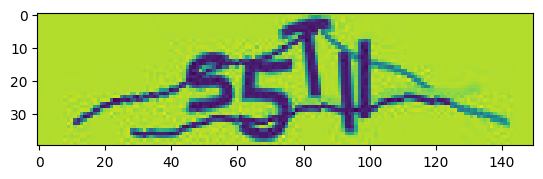

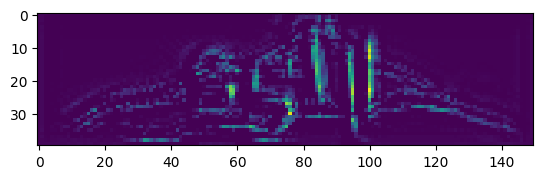

torch.Size([1, 5, 62])
S5ill


In [27]:
import matplotlib.pyplot as plt
with torch.no_grad():
    for X,y in train_loader:
        X=X[0]
        
        plt.imshow(X.numpy().transpose(1,2,0))
        plt.show()
        output=model(X.unsqueeze(0).to(device))
        X1=model.affn(X.unsqueeze(0).to(device))
        plt.imshow(X1[0].cpu().numpy().transpose(1,2,0))
        plt.show()
        print(output.shape)
        print(to_text(output.squeeze(0).argmax(axis=1)))
        break